In [4]:
from __future__ import division
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab

In [136]:
#balanced accuracy
def Balanced_acc(ypred,ytest):
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
        acc_class[c] = sum(correct)/len(correct)

    Bacc = acc_c/len(np.unique(ytest))
    return Bacc,acc_class

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'], rotation=45)
    plt.yticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def prec_rec(cmat):
    tpfp = cmat.sum(axis=1)
    tpfn = cmat.sum(axis=0)
    prec = cmat.diagonal()/tpfp
    recall = cmat.diagonal()/tpfn
    return prec,recall

### Load Data

In [6]:
HealthyData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/HealthyData.csv',verbose=False)
CBRData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientCBRData.csv',verbose=False)
SCOData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientSCOData.csv',verbose=False)

This non-commercial license of GraphLab Create for academic use is assigned to llonini@ricres.org and will expire on November 11, 2016.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\llonini\AppData\Local\Temp\graphlab_server_1475252075.log.0


In [7]:
HealthyCodes = HealthyData['SubjID'].unique()
HealthyCodes = HealthyCodes.sort()
print HealthyCodes
PatientCodes = CBRData['SubjID'].unique()
PatientCodes = PatientCodes.sort()
print PatientCodes

[51L, 52L, 53L, 54L, 55L, 56L, 57L, 58L, 59L, 60L, 61L]
[1L, 2L, 5L, 6L, 8L, 11L, 12L, 13L, 14L, 15L, 16L, 19L]


In [8]:
PatientCodes = np.array([1, 2, 5, 6, 8, 11, 14, 15, 16, 19]) #all patients with 4 sessions in SCO and CBR

### We use 4 sessions from both CBR and SCO data. Remove stairs CBR data for patients who don't have at least 2 sessions with stairs data

Inspect SCO Data

In [12]:
for s in PatientCodes:
    data = SCOData[SCOData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())

1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 3 4]
2 4 [0 1 2 3 4]
5 1 [0 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
6 1 [0 1 2 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 1 2 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 3 4]
11 1 [0 3 4]
11 2 [0 3 4]
11 3 [0 3 4]
11 4 [0 1 2 3 4]
14 1 [0 1 2 3 4]
14 2 [0 1 2 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 3 4]
15 3 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 1 2 3 4]
19 3 [0 3 4]


In [13]:
print SCOData.num_rows()

18762


Inspect CBR Data

In [21]:
for s in PatientCodes:
    data = CBRData[CBRData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 1 2 3 4]
2 4 [0 1 2 3 4]
5 1 [0 1 2 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
5 4 [0 1 2 3 4]
6 1 [0 1 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 3 4]
11 1 [0 3 4]
11 2 [0 1 2 3 4]
11 3 [0 1 2 3 4]
11 4 [0 1 2 3 4]
14 1 [0 3 4]
14 2 [0 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 1 2 3 4]
15 3 [0 3 4]
15 4 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 1 2 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 3 4]
19 3 [0 3 4]
19 4 [0 3 4]


* Remove stairs from CBR08 

In [16]:
Nostairs = [8] #the patient to remove stairs 
CBRDatanew = CBRData.filter_by(Nostairs,'SubjID',exclude=True)
for s in Nostairs:
    data = CBRData[(CBRData['SubjID']==s)].filter_by([0,3,4],'Label')
    CBRDatanew=CBRDatanew.append(data)

for s in PatientCodes:
    print s,CBRDatanew[CBRDatanew['SubjID']==s]['Label'].unique().sort()

1 [0L, 1L, 2L, 3L, 4L]
2 [0L, 1L, 2L, 3L, 4L]
5 [0L, 1L, 2L, 3L, 4L]
6 [0L, 1L, 2L, 3L, 4L]
8 [0L, 3L, 4L]
11 [0L, 1L, 2L, 3L, 4L]
14 [0L, 1L, 2L, 3L, 4L]
15 [0L, 1L, 2L, 3L, 4L]
16 [0L, 1L, 2L, 3L, 4L]
19 [0L, 3L, 4L]


All the CBR subjects have stairs except 2 of them

In [17]:
print CBRData.num_rows()
print CBRDatanew.num_rows()

22354
22323


In [18]:
CBRData = CBRDatanew

## Train RF on healthy 

In [216]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

RF = RandomForestClassifier(n_estimators=100)
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_H = [] #accuracy per class for each subject
cmat_H = {} #store confusion mats, precision and recall for all subjects  
prec_H = {} 
recall_H ={}
k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)]
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    print 'Test on Patient %s, Train samples=%s, Test samples=%s, Nclass test=%s'%(s,len(ytrain),len(ytest),Nclasses)
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_H.append(acc_class)  
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    #key = 'S'+np.array_str(s) #subj code
    cmat_H.update({s:cmat})
    prec_H.update({s:prec})
    recall_H.update({s:recall})
    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmedian Bacc - Healthy model = %s'%np.median(SOacc)

#acc_class_H_mean = np.nanmean(acc_class_H,axis=0)
prec_class_H_mean = np.nanmean(np.asarray(prec_H.values()),axis=0)
rec_class_H_mean = np.nanmean(np.asarray(recall_H.values()),axis=0)

Test on Patient 1, Train samples=8375, Test samples=1678, Nclass test=5
BAcc = 0.47
Test on Patient 2, Train samples=8375, Test samples=1458, Nclass test=5
BAcc = 0.34
Test on Patient 5, Train samples=8375, Test samples=1773, Nclass test=5
BAcc = 0.45
Test on Patient 6, Train samples=8375, Test samples=2916, Nclass test=5
BAcc = 0.58
Test on Patient 8, Train samples=8375, Test samples=1179, Nclass test=3
BAcc = 0.40
Test on Patient 11, Train samples=8375, Test samples=1708, Nclass test=5
BAcc = 0.52
Test on Patient 14, Train samples=8375, Test samples=1976, Nclass test=5
BAcc = 0.49
Test on Patient 15, Train samples=8375, Test samples=3511, Nclass test=5
BAcc = 0.44
Test on Patient 16, Train samples=8375, Test samples=1734, Nclass test=5
BAcc = 0.58
Test on Patient 19, Train samples=8375, Test samples=1565, Nclass test=3
BAcc = 0.57

median Bacc - Healthy model = 0.477090837196


In [215]:
np.savetxt('cmatHealthy.csv', np.asarray(prec_H.values()), delimiter=',') 
np.savetxt('precisionHealthy.csv', np.asarray(prec_H.values()), delimiter=',') 
np.savetxt('recallHealthy.csv', np.asarray(prec_H.values()), delimiter=',') 


In [214]:
np.asarray(prec_H.values())

array([[ 0.97009967,  0.03157895,  0.34285714,  0.6552795 ,  0.89473684],
       [ 0.94396552,  0.056     ,  0.70833333,  0.52513966,  0.39583333],
       [ 0.75806452,  0.        ,  0.27118644,  0.6125    ,  0.10351201],
       [ 0.63561077,         nan,         nan,  0.76426799,  0.30338733],
       [ 0.62527233,  0.0070922 ,  0.68421053,  0.84789157,  0.04830918],
       [ 0.89090909,  0.0733945 ,  0.73913043,  0.89836449,  0.21948998],
       [ 0.8616188 ,         nan,         nan,  0.18661972,  0.03125   ],
       [ 0.6894198 ,  0.18181818,  0.66666667,  0.79423077,  0.28908189],
       [ 0.66031196,  0.        ,  0.05063291,  0.85087719,  0.8766328 ],
       [ 0.98031026,  0.        ,  0.35294118,  0.78277886,  0.29568106]])

In [199]:
a = prec_H.values()
b = np.asarray(a)
print b
np.nanmean(b,axis=0)

[[ 0.97342193  0.03157895  0.3047619   0.62732919  0.88624788]
 [ 0.89224138  0.048       0.73333333  0.43389199  0.17361111]
 [ 0.75483871  0.          0.22033898  0.62083333  0.14972274]
 [ 0.65424431         nan         nan  0.76674938  0.28424153]
 [ 0.65577342  0.          0.78947368  0.82680723  0.04589372]
 [ 0.90629371  0.10091743  0.80434783  0.88317757  0.17577413]
 [ 0.87467363         nan         nan  0.16197183  0.0234375 ]
 [ 0.69283276  0.13636364  0.71111111  0.80192308  0.32754342]
 [ 0.70363951  0.          0.07594937  0.84385965  0.86647315]
 [ 0.98627685  0.          0.23529412  0.77690802  0.17109635]]


array([ 0.80942362,  0.0396075 ,  0.48432629,  0.67434513,  0.31040415])

## Global model SCO (Leave one subject out)

In [51]:
ISpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] 
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Nsamples[k] = ytrain.shape[0]
    
    RF = RandomForestClassifier(n_estimators=100)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Nsamples train = {}, Global SCO model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,Nsamples[k],ISpec_acc[k])
    k = k+1

print 'Median BAcc - Impairment Specific (SCO) = %s'%np.median(ISpec_acc)
print 'Avg train size = {}'.format(np.mean(Nsamples))

Patient 1, Nclass train = 5, Nclass test = 5, Nsamples train = 17471.0, Global SCO model - BAcc = 0.58
Patient 2, Nclass train = 5, Nclass test = 5, Nsamples train = 17055.0, Global SCO model - BAcc = 0.43
Patient 5, Nclass train = 5, Nclass test = 5, Nsamples train = 16386.0, Global SCO model - BAcc = 0.48
Patient 6, Nclass train = 5, Nclass test = 5, Nsamples train = 17383.0, Global SCO model - BAcc = 0.56
Patient 8, Nclass train = 5, Nclass test = 3, Nsamples train = 16142.0, Global SCO model - BAcc = 0.44
Patient 11, Nclass train = 5, Nclass test = 5, Nsamples train = 17131.0, Global SCO model - BAcc = 0.56
Patient 14, Nclass train = 5, Nclass test = 5, Nsamples train = 16787.0, Global SCO model - BAcc = 0.59
Patient 15, Nclass train = 5, Nclass test = 5, Nsamples train = 16899.0, Global SCO model - BAcc = 0.54
Patient 16, Nclass train = 5, Nclass test = 5, Nsamples train = 16097.0, Global SCO model - BAcc = 0.55
Patient 19, Nclass train = 5, Nclass test = 3, Nsamples train = 17507

## Global model CBR (Leave one subject out)

In [24]:
ISpecCBR_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = CBRData[(CBRData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] #test on 3 CBR sessions
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpecCBR_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Global CBR model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,ISpecCBR_acc[k])
    k = k+1

print 'Median BAcc - Global CBR model = %s'%np.median(ISpecCBR_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.61
Patient 2, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.44
Patient 5, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.54
Patient 6, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.57
Patient 8, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.56
Patient 11, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.57
Patient 14, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.54
Patient 15, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.60
Patient 16, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.60
Patient 19, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.88
Median BAcc - Global CBR model = 0.57144592259


## Personal SCO (Patient Specific model) 

In [52]:
PSpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] == s)]
    test = CBRData[(CBRData['SubjID'] == s)]
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Nsamples[k] = ytrain.shape[0]

    RF = RandomForestClassifier(n_estimators=50)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    PSpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    
    print 'Patient {}, Nclass train = {}, Nclass test = {},  Nsamples train = {}, Personal SCO model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,Nsamples[k],PSpec_acc[k])
    k = k+1

print 'Median BAcc - Patient Specific (SCO) = %s'%np.median(PSpec_acc)
print 'Avg train size = {}'.format(np.mean(Nsamples))

Patient 1, Nclass train = 5, Nclass test = 5,  Nsamples train = 1291.0, Personal SCO model - BAcc = 0.74
Patient 2, Nclass train = 5, Nclass test = 5,  Nsamples train = 1707.0, Personal SCO model - BAcc = 0.48
Patient 5, Nclass train = 5, Nclass test = 5,  Nsamples train = 2376.0, Personal SCO model - BAcc = 0.64
Patient 6, Nclass train = 5, Nclass test = 5,  Nsamples train = 1379.0, Personal SCO model - BAcc = 0.60
Patient 8, Nclass train = 5, Nclass test = 3,  Nsamples train = 2620.0, Personal SCO model - BAcc = 0.80
Patient 11, Nclass train = 5, Nclass test = 5,  Nsamples train = 1631.0, Personal SCO model - BAcc = 0.46
Patient 14, Nclass train = 5, Nclass test = 5,  Nsamples train = 1975.0, Personal SCO model - BAcc = 0.53
Patient 15, Nclass train = 5, Nclass test = 5,  Nsamples train = 1863.0, Personal SCO model - BAcc = 0.46
Patient 16, Nclass train = 5, Nclass test = 5,  Nsamples train = 2665.0, Personal SCO model - BAcc = 0.45
Patient 19, Nclass train = 5, Nclass test = 3,  Nsa

## Personal CBR (Patient and Device specific model) 
Leave One Session Out 

In [62]:
len(range(1,5))

4

In [65]:
DSpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
k = 0
for s in PatientCodes:
    
    data =  CBRData[(CBRData['SubjID'] == s)] 
    Bacc = np.zeros(4)
    for session in range(1,5):
                  
        test = data[data['Session'] == session]
        train = data[data['Session'] != session]
        Nclasstrain = len(train['Label'].unique())
        Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1)
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)
        Nsamples[k] = Nsamples[k]+ytrain.shape[0]

        RF = RandomForestClassifier(n_estimators=50)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)
        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy on each session
        Bacc[session-1],acc_class = Balanced_acc(ypred,ytest)
        print 'Nclass train = {}, Nclass test ={}, BAcc = {:.2f}'.format(Nclasstrain,Nclasses,Bacc[session-1])

    DSpec_acc[k] = Bacc.mean() #the CV BAcc on 4 sessions 
    Nsamples[k] = Nsamples[k]/len(range(1,5)) #mean number of samples across sessions
    print 'Patient {}, Device Specific model - BAcc = {:.2f}'.format(s,DSpec_acc[k])
    k = k+1

print 'Median BAcc - Device Specific (CBR) = %s'%(np.median(DSpec_acc))
print 'Avg train size = {}'.format(np.mean(Nsamples))

Nclass train = 5, Nclass test =5, BAcc = 0.87
Nclass train = 5, Nclass test =5, BAcc = 0.83
Nclass train = 5, Nclass test =5, BAcc = 0.90
Nclass train = 5, Nclass test =5, BAcc = 0.75
Patient 1, Device Specific model - BAcc = 0.84
Nclass train = 5, Nclass test =5, BAcc = 0.67
Nclass train = 5, Nclass test =5, BAcc = 0.56
Nclass train = 5, Nclass test =5, BAcc = 0.71
Nclass train = 5, Nclass test =5, BAcc = 0.59
Patient 2, Device Specific model - BAcc = 0.63
Nclass train = 5, Nclass test =5, BAcc = 0.73
Nclass train = 5, Nclass test =5, BAcc = 0.62
Nclass train = 5, Nclass test =5, BAcc = 0.62
Nclass train = 5, Nclass test =5, BAcc = 0.67
Patient 5, Device Specific model - BAcc = 0.66
Nclass train = 5, Nclass test =4, BAcc = 0.66
Nclass train = 5, Nclass test =5, BAcc = 0.50
Nclass train = 5, Nclass test =5, BAcc = 0.64
Nclass train = 5, Nclass test =5, BAcc = 0.73
Patient 6, Device Specific model - BAcc = 0.63
Nclass train = 3, Nclass test =3, BAcc = 0.95
Nclass train = 3, Nclass test 

In [66]:
acc_all=np.vstack((SOacc,ISpec_acc,PSpec_acc,DSpec_acc)).T
print acc_all

[[ 0.48298527  0.5846473   0.73909029  0.83685632]
 [ 0.34437885  0.42904702  0.47886228  0.63212783]
 [ 0.45225881  0.47617987  0.64252476  0.66014189]
 [ 0.58308531  0.55990783  0.59889354  0.63104542]
 [ 0.34432134  0.44482886  0.80218164  0.91720168]
 [ 0.52072587  0.56367906  0.46346476  0.65104976]
 [ 0.49155385  0.58865768  0.5315459   0.81747341]
 [ 0.481689    0.54265962  0.45776484  0.78135606]
 [ 0.58665849  0.55470282  0.45111261  0.76550067]
 [ 0.54362576  0.83898528  0.77970136  0.78181088]]


<function matplotlib.pyplot.show>

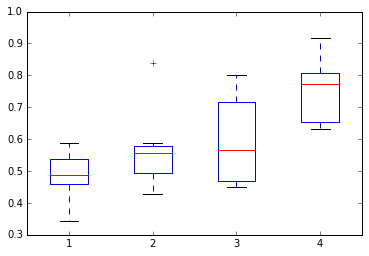

In [67]:
plt.boxplot(acc_all)
plt.show

In [68]:
np.median(SOacc)

0.48726956038769192

In [69]:
np.median(ISpec_acc)

0.55730532081054629

In [70]:
np.median(PSpec_acc)

0.56521971966507611

In [71]:
np.median(DSpec_acc)

0.77342836327796771

In [72]:
np.savetxt('results.csv', acc_all, delimiter=',') 

## Distribution of accuracy per class